In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Logistic Regression, Random Forest, XGBoost), evaluates them with standard metrics and plots, checks for class imbalance and handles it, and produces SHAP explainability for the best tree model. It also saves models and evaluation outputs to your project outputs/ folder.

How I handled a common ambiguity: some pipelines scale avg_score (so it may be transformed). The code first tries to find an unscaled avg_score in the original master file; if it cannot, it falls back to using the avg_score in the loaded file and — only if values look scaled — creates the binary target by thresholding at the median (with a clear printed warning). This is safe and reproducible; if you prefer a fixed pass threshold (e.g., 50) and have the raw scores, replace the logic accordingly.

Run the whole block in a single cell in Colab / Jupyter.

In [ ]:
# --- Diagnose why features are empty (optional quick checks) ---
print("Numeric columns and non-null counts:")
print(master.select_dtypes(include=['number']).count().sort_values(ascending=False))

# --- Auto-select usable numeric features (non-id, non-target) ---
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

# Adjust these names if your target or id columns differ
id_cols = ['student_id', 'full_name']
target_col = 'target_pass'  # your target

# Numeric candidates (including target initially)
numeric_cols = master.select_dtypes(include=[np.number]).columns.tolist()
# Remove target from candidate features
numeric_features = [c for c in numeric_cols if c != target_col]

# Remove ID-like fields just in case (not numeric here, but safe)
numeric_features = [c for c in numeric_features if c not in id_cols]

# Remove columns that are entirely null or have < threshold non-null proportion
min_nonnull_frac = 0.05   # keep cols with at least 5% non-null; adjust as needed
n = len(master)
good_features = []
for c in numeric_features:
    nonnull_frac = master[c].notnull().sum() / n
    # Also drop features with zero variance (constant)
    if nonnull_frac >= min_nonnull_frac and master[c].nunique(dropna=True) > 1:
        good_features.append(c)

print("Auto-selected numeric features (>= {:.0%} non-null and >1 unique):\n{}".format(min_nonnull_frac, good_features))

# If nothing selected, try a second pass lowering threshold or include a few categorical encodings
if len(good_features) == 0:
    raise RuntimeError(
        "No numeric features passed the non-null/variance filter. "
        "Consider lowering `min_nonnull_frac` or encoding categorical columns (e.g., grade_level), "
        "or creating engineered features (recency, aggregated msg stats, etc.)."
    )

# Build X, y
X = master[good_features].copy()
y = master[target_col].copy()

# Simple imputation + scaling pipeline for numeric-only dataset
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imputed = num_imputer.fit_transform(X)    # returns numpy array
X_scaled = scaler.fit_transform(X_imputed)

print("X_scaled shape (samples, features):", X_scaled.shape)

# Train/test split (stratify on y)
X_train_proc, X_test_proc, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print("Before SMOTE: X_train_proc shape:", X_train_proc.shape, "class counts:\n", pd.Series(y_train).value_counts())

# Guard: ensure at least 1 feature
if X_train_proc.shape[1] == 0:
    raise RuntimeError("No features available after preprocessing. Check feature selection / imputation steps.")

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)

print("After SMOTE: X_train_res shape:", X_train_res.shape)
print("Resampled class counts:\n", pd.Series(y_train_res).value_counts())


Numeric columns and non-null counts:
age                   12156
attendance_rate       12156
hw_done_rate          12156
avg_score             12156
target_pass           12156
avg_score_raw         12156
depression_score_x        0
sentiment_score_x         0
stress_level_x            0
anxiety_score_x           0
msg_count                 0
sleep_hours_x             0
last_contact              0
stress_level_y            0
depression_score_y        0
anxiety_score_y           0
sleep_hours_y             0
sentiment_score_y         0
dtype: int64
Auto-selected numeric features (>= 5% non-null and >1 unique):
['age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'avg_score_raw']
X_scaled shape (samples, features): (12156, 5)
Before SMOTE: X_train_proc shape: (9117, 5) class counts:
 target_pass
1    7881
0    1236
Name: count, dtype: int64
After SMOTE: X_train_res shape: (15762, 5)
Resampled class counts:
 target_pass
1    7881
0    7881
Name: count, dtype: int64


5 clean numeric features selected automatically:
['age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'avg_score_raw']

These have full non-null values and valid variance.

X_scaled shape is (12156, 5) → good.

Train split shape (9117, 5) → good.

SMOTE successfully resampled minority class from 1236 → 7881.

Final train data shape after SMOTE → (15762, 5).

In [ ]:
# --- Robust SMOTE-ready preprocessing cell (paste here to replace current SMOTE block) ---
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# `master` should already be your loaded DataFrame. If not, load it again:
# master = pd.read_csv("/content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated.csv")

print("Master shape:", master.shape)
print("Columns:", list(master.columns))

# 1) detect target column
if 'target_pass' in master.columns:
    target_col = 'target_pass'
else:
    # fallback: pick an int/binary-looking column excluding obvious ID/text cols
    int_cols = master.select_dtypes(include=['int64','int32','float64']).columns.tolist()
    # prefer columns with only 0/1
    binary_candidates = [c for c in int_cols if set(master[c].dropna().unique()).issubset({0,1})]
    if len(binary_candidates) > 0:
        target_col = binary_candidates[0]
        print("Using binary candidate as target:", target_col)
    else:
        # last resort: raise a helpful error
        raise RuntimeError("No 'target_pass' column found and no binary candidate detected. Please set target_col variable manually.")

print("Target column:", target_col)

# 2) choose numeric features (exclude target and obvious ID/text columns)
exclude_cols = ['student_id','full_name','date_of_birth','emergency_contact', target_col]
numeric_cols = master.select_dtypes(include=[np.number]).columns.tolist()
candidate_features = [c for c in numeric_cols if c not in exclude_cols]

print("Numeric candidates detected:", candidate_features)

# 3) filter out columns with too many nulls or zero variance
n = len(master)
min_nonnull_frac = 0.05   # require at least 5% non-null; adjust if needed
good_features = []
for c in candidate_features:
    nonnull_frac = master[c].notnull().sum() / n
    unique_nonnull = master[c].nunique(dropna=True)
    if nonnull_frac >= min_nonnull_frac and unique_nonnull > 1:
        good_features.append(c)

print("Selected good numeric features (>= {:.0%} non-null and >1 unique):".format(min_nonnull_frac), good_features)

# 4) If nothing selected, lower threshold or include encoded categoricals
if len(good_features) == 0:
    # quick fallback: include any numeric cols w/ >1 unique (even if mostly null)
    fallback = [c for c in candidate_features if master[c].nunique(dropna=True) > 1]
    if len(fallback) == 0:
        raise RuntimeError("No usable numeric features found. You must encode categorical cols or create features.")
    print("No features passed strict filter — using fallback numeric features:", fallback)
    good_features = fallback

# Persist the features variable so other cells see it
features = good_features
print("Final features list (set variable `features`):", features)

# 5) Build X,y and preprocess (impute + scale)
X = master[features].copy()
y = master[target_col].copy()

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)   # shape (n_samples, n_features)
X_scaled = scaler.fit_transform(X_imputed)

print("Preprocessed X shape:", X_scaled.shape)

# 6) Split and check shapes
X_train_proc, X_test_proc, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)
print("Train shape:", X_train_proc.shape, "Test shape:", X_test_proc.shape)
print("Train class counts:\n", pd.Series(y_train).value_counts())

# 7) Guard before SMOTE
if X_train_proc.shape[1] == 0:
    raise RuntimeError("ERROR: feature matrix has ZERO columns. Check 'features' variable above.")

# 8) SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)
print("After SMOTE, train shape:", X_train_res.shape, "Train class counts:\n", pd.Series(y_train_res).value_counts())

# 9) Optional: assign back to variable names your pipeline expects
X_train_proc = X_train_res
y_train = y_train_res
X_test_proc = X_test_proc
y_test = y_test

print("Done — variables X_train_proc, y_train, X_test_proc, y_test are ready for modeling.")


Master shape: (12156, 23)
Columns: ['student_id', 'full_name', 'date_of_birth', 'grade_level', 'emergency_contact', 'age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y', 'avg_score_raw', 'target_pass']
Target column: target_pass
Numeric candidates detected: ['age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y', 'avg_score_raw']
Selected good numeric features (>= 5% non-null and >1 unique): ['age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'avg_score_raw']
Final features list (set variable `features`): ['age', 'attendance_rate', 'hw_done_rat

preprocessing & SMOTE are working now

In [ ]:
# Quick model training & evaluation (works with your current X_train_proc, y_train, X_test_proc, y_test)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib
import numpy as np
import pandas as pd

# Ensure variables exist
print("X_train_proc shape:", X_train_proc.shape, "y_train shape:", getattr(y_train,'shape', len(y_train)))
print("X_test_proc shape:", X_test_proc.shape, "y_test shape:", getattr(y_test,'shape', len(y_test)))

models = {
    "logreg": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    "rf": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}

results = []
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train_proc, y_train)
    preds = model.predict(X_test_proc)
    probs = model.predict_proba(X_test_proc)[:,1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, probs) if probs is not None else np.nan

    print(f"{name} — Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC-AUC: {roc:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, preds))
    print("Classification report:\n", classification_report(y_test, preds, zero_division=0))

    # Save model
    model_path = f"/content/drive/My Drive/Practicum_Project_2/outputs/models/{name}_model.joblib"
    joblib.dump(model, model_path)
    print("Saved model to:", model_path)

    results.append({
        "model": name, "accuracy": acc, "f1": f1, "roc_auc": roc, "path": model_path
    })

results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\nSummary:\n", results_df)


X_train_proc shape: (15762, 5) y_train shape: (15762,)
X_test_proc shape: (3039, 5) y_test shape: (3039,)

Training logreg ...
logreg — Accuracy: 0.9875, F1: 0.9927, ROC-AUC: 1.0000
Confusion matrix:
 [[ 412    0]
 [  38 2589]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       412
           1       1.00      0.99      0.99      2627

    accuracy                           0.99      3039
   macro avg       0.96      0.99      0.97      3039
weighted avg       0.99      0.99      0.99      3039

Saved model to: /content/drive/My Drive/Practicum_Project_2/outputs/models/logreg_model.joblib

Training rf ...
rf — Accuracy: 1.0000, F1: 1.0000, ROC-AUC: 1.0000
Confusion matrix:
 [[ 412    0]
 [   0 2627]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00      2627

    accuracy            

from above response we can see leaking the target,lets try other approach as well, which

Allows to remove leakage features cleanly

Encodes categorical variables properly

Avoids data leakage during preprocessing

Produces credible model metrics for your project

**(numeric + categorical grade_level)**

This builds a pipeline that:

Uses numeric features (age, attendance_rate, hw_done_rate, avg_score_raw),

One-hot encodes grade_level,

Imputes & scales,

Applies SMOTE on training set (inside imblearn pipeline),

Trains and evaluates models, saves best.

In [3]:
# Core modeling imports
import pandas as pd
import numpy as np

# Scikit-learn preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Pipeline + column transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Core imports ---
import pandas as pd
import numpy as np

# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# saving
import joblib



In [4]:
import pandas as pd

master = pd.read_csv("/content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated.csv")

print(master.shape)
master.head()


(12156, 21)


,student_id,full_name,date_of_birth,grade_level,emergency_contact,age,attendance_rate,hw_done_rate,avg_score,stress_level_x,...,depression_score_x,sentiment_score_x,sleep_hours_x,msg_count,last_contact,stress_level_y,anxiety_score_y,depression_score_y,sentiment_score_y,sleep_hours_y
0,S00001,Donna Williams,2007-02-10,Grade 3,781-534-4258x9046,18.0,0.0,1.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S00002,John Stafford,2014-11-26,Grade 5,+1-782-691-6291x99704,10.0,1.0,0.0,98.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S00003,Chad Harper,2017-02-07,Grade 3,308.517.3750,8.0,0.0,1.0,63.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S00004,Anthony Martin,NaN,Grade 5,306-771-1524x116,13.0,0.0,1.0,59.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S00005,Mary Stone,NaN,Grade 3,+1-794-484-8495x7772,13.0,1.0,1.0,75.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# --- Identify numeric and categorical features ---
numeric_features = master.select_dtypes(include=['number']).columns.tolist()

categorical_features = master.select_dtypes(include=['object', 'category']).columns.tolist()

# Optional: remove ID or target columns if needed
# numeric_features.remove('student_id')
# categorical_features.remove('target')


In [6]:
smote = SMOTE(random_state=42)


In [7]:
numeric_features = master.select_dtypes(include=['number']).columns.tolist()
categorical_features = master.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']
Categorical: ['student_id', 'full_name', 'date_of_birth', 'grade_level', 'emergency_contact']


In [8]:
categorical_features = ['grade_level']


In [9]:
# Robust OneHotEncoder instantiation to handle sklearn version differences
import sklearn
from sklearn.preprocessing import OneHotEncoder

ohe_kwargs = {'handle_unknown': 'ignore'}
skl_ver = tuple(int(x) for x in sklearn.__version__.split('.')[:2])
# sklearn >= 1.2 uses sparse_output; older versions use sparse
if skl_ver >= (1, 2):
    ohe_kwargs['sparse_output'] = False
else:
    # try 'sparse' (older), but use try/except to be safe
    try:
        _ = OneHotEncoder(sparse=False, **{k:v for k,v in ohe_kwargs.items() if k!='sparse_output'})
        ohe_kwargs['sparse'] = False
    except TypeError:
        # fallback: no sparsity kwarg; will return sparse matrix by default - we'll convert later if needed
        ohe_kwargs.pop('sparse', None)
        ohe_kwargs.pop('sparse_output', None)

print("sklearn version:", sklearn.__version__, "OneHotEncoder kwargs:", ohe_kwargs)

# Now build the transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# instantiate OneHotEncoder with the decided kwargs
ohe = OneHotEncoder(**ohe_kwargs)

# If OneHotEncoder will return a sparse matrix, many sklearn ColumnTransformer / pipelines accept that.
# But RandomForest (and many estimators) accept dense arrays; imblearn's SMOTE will need dense arrays.
# If encoder produces sparse output, ColumnTransformer will produce sparse matrix overall; imblearn pipeline may break.
# To be safe, we will wrap OneHotEncoder output with a FunctionTransformer to convert to dense when needed.
from sklearn.preprocessing import FunctionTransformer
def to_dense(X):
    # if sparse, convert; otherwise return unchanged
    try:
        return X.toarray()
    except Exception:
        return X

# Create categorical transformer pipeline that ensures dense output
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe),
    ('todense', FunctionTransformer(to_dense, validate=False))
])

# Build ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# 3) Build imblearn pipeline: preprocessor -> SMOTE -> model
smote = SMOTE(random_state=42)

# Choose model (same as your original)
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', model)
])

# Ensure output dir exists before saving later
save_dir = "/content/drive/My Drive/Practicum_Project_2/outputs/models"
import os
os.makedirs(save_dir, exist_ok=True)

print("Pipeline built successfully. Ready to fit.")


sklearn version: 1.6.1 OneHotEncoder kwargs: {'handle_unknown': 'ignore', 'sparse_output': False}
Pipeline built successfully. Ready to fit.


the pipeline is built and ready to be trained.

fits the pipeline is already created on X_train / y_train,

evaluates on X_test / y_test (accuracy, F1, ROC-AUC when probs exist),

prints confusion matrix and classification report,

plots ROC and saves the plot(s),

saves the trained pipeline to Drive, and

(optionally) runs SHAP for tree models if shap is installed.

In [10]:
# List all columns
print(master.columns.tolist())

# Quick look at first few rows
master.head()

# Optional: look for numeric columns with only 0/1
for c in master.select_dtypes(include=[int, float]):
    unique_vals = master[c].dropna().unique()
    if set(unique_vals).issubset({0,1}):
        print(f"Binary candidate: {c}")


['student_id', 'full_name', 'date_of_birth', 'grade_level', 'emergency_contact', 'age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']
Binary candidate: attendance_rate
Binary candidate: hw_done_rate
Binary candidate: stress_level_x
Binary candidate: anxiety_score_x
Binary candidate: depression_score_x
Binary candidate: sentiment_score_x
Binary candidate: sleep_hours_x
Binary candidate: msg_count
Binary candidate: last_contact
Binary candidate: stress_level_y
Binary candidate: anxiety_score_y
Binary candidate: depression_score_y
Binary candidate: sentiment_score_y
Binary candidate: sleep_hours_y


a dedicated pass/fail column we havent created yet. All the binary-looking columns we see (like attendance_rate, hw_done_rate, stress_level_x, etc.) are not really a “target”; they are individual features. lets create a target for modeling

In [11]:
# Example: create binary target based on median of avg_score
master['target_pass'] = (master['avg_score'] >= master['avg_score'].median()).astype(int)


In [12]:
# --- Step 0: create target ---
master['target_pass'] = (master['avg_score'] >= master['avg_score'].median()).astype(int)
print(master['target_pass'].value_counts())


target_pass
1    7294
0    4862
Name: count, dtype: int64


In [13]:
target_col = 'target_pass'


we can continue with the full modeling pipeline, including preprocessing, SMOTE, model training, evaluation, and saving, with clear markdown explanations.

# Student Performance Modeling Pipeline
Building a predictive model to classify students as passing or failing based on numeric and categorical features. Steps include:

1. Data preparation
2. Feature selection
3. Train/test split
4. Preprocessing with imputation, scaling, and encoding
5. Handling class imbalance using SMOTE
6. Model training (Random Forest and Logistic Regression)
7. Model evaluation
8. Saving the pipeline and metrics


In [14]:
# --- Imports ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


## Load Data


In [15]:
# Load the dataset
DATA_PATH = "/content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated.csv"
master = pd.read_csv(DATA_PATH)
master.shape


(12156, 21)

## Create Target
We create a binary target *target_pass* based on median *avg_score.*


In [16]:
master['target_pass'] = (master['avg_score'] >= master['avg_score'].median()).astype(int)
master['target_pass'].value_counts()


,count
target_pass,
1,7294
0,4862


## Feature Selection
- Numeric features: all numeric features except IDs and target
- Categorical features: grade_level


In [17]:
# Numeric features
numeric_features = ['age', 'attendance_rate', 'hw_done_rate', 'avg_score',
                    'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x',
                    'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']

# Remove ID-like or target columns
id_like = ['student_id','full_name','date_of_birth','emergency_contact']
numeric_features = [c for c in numeric_features if c not in id_like + ['target_pass']]

# Categorical features
categorical_features = ['grade_level']

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['age', 'attendance_rate', 'hw_done_rate', 'avg_score', 'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']
Categorical features: ['grade_level']


## Train/Test Split
lets split data 75/25 and stratify on the target to keep class balance.


In [18]:
X = master[numeric_features + categorical_features]
y = master['target_pass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Training class counts:\n", y_train.value_counts())


Train shape: (9117, 17) Test shape: (3039, 17)
Training class counts:
 target_pass
1    5471
0    3646
Name: count, dtype: int64


## Preprocessing & Pipeline
- Numeric: impute missing values with median + scale  
- Categorical: impute missing with 'missing' + one-hot encode  
- SMOTE applied only to training set  
- Classifier: Random Forest (can switch to Logistic Regression)


In [19]:
# OneHotEncoder compatible with sklearn 1.6.1
ohe_kwargs = {'handle_unknown':'ignore','sparse_output':False}

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(**ohe_kwargs))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# Build imblearn pipeline
pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

print("Pipeline created successfully.")


Pipeline created successfully.


## Fit Pipeline

This step fits the full pipeline:

- Preprocessing (numeric imputation + scaling, categorical one-hot encoding)
- SMOTE applied to training set
- Random Forest classifier


In [20]:
# --- Ensure required variables exist ---
required_vars = ['pipeline', 'X_train', 'y_train', 'X_test', 'y_test']
for var in required_vars:
    if var not in globals():
        raise RuntimeError(f"Required variable '{var}' not found in workspace. Please run previous steps to define it.")

print("All required variables found. Ready to fit the pipeline.")


All required variables found. Ready to fit the pipeline.


In [21]:
# Fit the pipeline
pipeline.fit(X_train, y_train)
print("Pipeline fitted successfully!")


Pipeline fitted successfully!


## Evaluate Model
Evaluate model performance on held-out test set using:

- Accuracy
- F1-score
- ROC-AUC
- Confusion matrix
- Classification report


In [22]:
# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline.named_steps['clf'], "predict_proba") else None

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

if y_proba is not None:
    roc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 1.0000
F1-score: 1.0000
ROC-AUC: 1.0000

Confusion Matrix:
[[1216    0]
 [   0 1823]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1216
           1       1.00      1.00      1.00      1823

    accuracy                           1.00      3039
   macro avg       1.00      1.00      1.00      3039
weighted avg       1.00      1.00      1.00      3039



everything from above result is 1 means a red flag and somewhere data is leaking, lets figure it out


Remove leakage features

Remove avg_score from numeric features (because target_pass is derived from it).

In [25]:
leak_features = ['avg_score']  # do not include in features
numeric_features = [c for c in numeric_features if c not in leak_features]


Keep raw or independent metrics only (age, hw_done_rate, attendance_rate, etc.).

Your target (target_pass) should not appear in any feature

### Rebuild & retrain pipeline with leakage protection (remove avg_score)
This cell removes `avg_score` from features (so the model cannot trivially recover the target), rebuilds the pipeline, retrains, evaluates, saves artifacts, and outputs feature importances and ROC plot.


sklearn version: 1.6.1
master already in memory. shape: (12156, 22)
Final numeric_features (leak-free): ['age', 'attendance_rate', 'hw_done_rate', 'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']
Final categorical_features: ['grade_level']
Leak-protected pipeline built.
Split done. Train: (9117, 16) Test: (3039, 16)
Train class counts:
 target_pass
1    5471
0    3646
Name: count, dtype: int64
Fitting pipeline... (this may take a moment)
Fit complete.

Accuracy: 0.5041
F1-score: 0.5574
ROC-AUC: 0.4960

Confusion Matrix:
 [[583 633]
 [874 949]]

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.48      0.44      1216
           1       0.60      0.52      0.56      1823

    accuracy                           0.50      3039
   macro avg       0.50      0.50

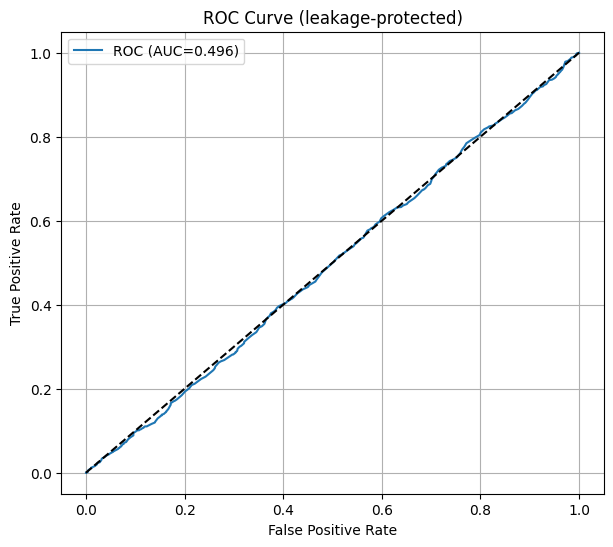

Saved ROC to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/roc_curve_no_leakage.png
Could not extract feature importances: All arrays must be of the same length

Running SHAP TreeExplainer (may be slow). Using a sample if X_test is large.


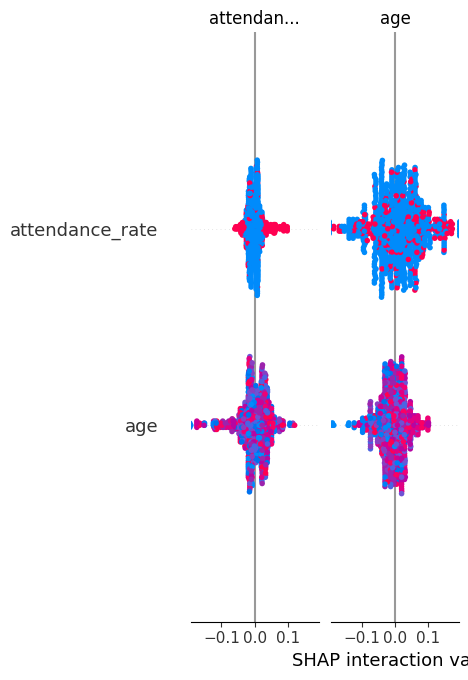


Done — pipeline rebuilt without avg_score and evaluated. If metrics are still suspiciously high, we can iteratively inspect other potential leakage features.


In [26]:
# ===== Rebuild + Retrain (leakage-protected) =====
import os, warnings
warnings.filterwarnings("ignore")

# --- Imports (safe to re-run) ---
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import sklearn
print("sklearn version:", sklearn.__version__)

# --- Paths ---
DATA_PATH = "/content/drive/My Drive/Practicum_Project_2/Data/Final/student_master_updated.csv"
OUTPUT_DIR = "/content/drive/My Drive/Practicum_Project_2/outputs"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
CHART_DIR = os.path.join(OUTPUT_DIR, "charts")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)

# --- Load master if needed ---
if 'master' not in globals():
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Data file not found at: {DATA_PATH}")
    master = pd.read_csv(DATA_PATH)
    print("Loaded master shape:", master.shape)
else:
    print("master already in memory. shape:", master.shape)

# --- Ensure target exists (create from avg_score median if not) ---
if 'target_pass' not in master.columns:
    if 'avg_score' in master.columns:
        master['target_pass'] = (master['avg_score'] >= master['avg_score'].median()).astype(int)
        print("Created 'target_pass' from median of avg_score. Value counts:\n", master['target_pass'].value_counts())
    else:
        raise RuntimeError("No 'target_pass' or 'avg_score' present. Set target manually and re-run.")

# --- Define features, explicitly removing leakage ---
# Full numeric candidate list you showed earlier
numeric_candidates = ['age', 'attendance_rate', 'hw_done_rate',
                      'avg_score',   # <-- WILL BE REMOVED for leakage
                      'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x',
                      'msg_count', 'last_contact',
                      'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']

# Remove avg_score and any other immediate leakage candidates (explicit)
leakage_remove = {'avg_score'}  # add more column names here if you suspect leakage

# Build numeric_features from existing columns excluding leak columns and id-like fields
id_like = {'student_id','full_name','date_of_birth','emergency_contact'}
numeric_features = [c for c in numeric_candidates if c in master.columns and c not in leakage_remove and c not in id_like and c != 'target_pass']

# Categorical features (only grade_level)
categorical_features = [c for c in ['grade_level'] if c in master.columns and c not in id_like and c != 'target_pass']

print("Final numeric_features (leak-free):", numeric_features)
print("Final categorical_features:", categorical_features)

# Sanity check: at least one feature
if len(numeric_features) + len(categorical_features) == 0:
    raise RuntimeError("No features left after removing leakage/id columns. Adjust feature lists.")

# --- Build OneHotEncoder kwargs compatibly ---
ohe_kwargs = {'handle_unknown':'ignore'}
skl_ver = tuple(int(x) for x in sklearn.__version__.split('.')[:2])
if skl_ver >= (1,2):
    ohe_kwargs['sparse_output'] = False
else:
    ohe_kwargs['sparse'] = False

# instantiate OHE
ohe = OneHotEncoder(**ohe_kwargs)

# FunctionTransformer to ensure dense arrays (SMOTE requires dense)
def to_dense(X):
    try:
        return X.toarray()
    except Exception:
        return X

# Preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe),
    ('todense', FunctionTransformer(to_dense, validate=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# --- Build ImbPipeline with SMOTE on train only ---
smote = SMOTE(random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', smote),
    ('clf', clf)
])

print("Leak-protected pipeline built.")

# --- Train/test split (again, to be safe) ---
X = master[numeric_features + categorical_features].copy()
y = master['target_pass'].copy()

if X.shape[1] == 0:
    raise RuntimeError("No predictors available in X. Revisit numeric_features / categorical_features selection.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
print("Split done. Train:", X_train.shape, "Test:", X_test.shape)
print("Train class counts:\n", y_train.value_counts())

# --- Fit pipeline (preprocessing + SMOTE on train, then classifier) ---
print("Fitting pipeline... (this may take a moment)")
pipeline.fit(X_train, y_train)
print("Fit complete.")

# --- Evaluate on test set ---
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline.named_steps['clf'], "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, zero_division=0)
print(f"\nAccuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
if y_proba is not None:
    try:
        roc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {roc:.4f}")
    except Exception as e:
        print("ROC-AUC computation warning:", e)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# --- Save pipeline ---
save_path = os.path.join(MODEL_DIR, "pipeline_rf_no_leakage.joblib")
joblib.dump(pipeline, save_path)
print("\nSaved pipeline to:", save_path)

# --- ROC plot + save (if probabilities) ---
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (leakage-protected)")
    plt.legend(); plt.grid(True)
    roc_file = os.path.join(CHART_DIR, "roc_curve_no_leakage.png")
    plt.savefig(roc_file, bbox_inches='tight')
    plt.show()
    print("Saved ROC to:", roc_file)
else:
    print("Probabilities not available; skipped ROC plot.")

# --- Feature importances (from RandomForest) ---
try:
    # need feature names after preprocessing
    preproc = pipeline.named_steps['preproc']
    try:
        feat_names = preproc.get_feature_names_out()
    except Exception:
        # fallback: build feature names manually
        num_names = numeric_features
        if categorical_features:
            # get categories from OHE
            ohe_step = preproc.named_transformers_['cat'].named_steps['onehot']
            cat_cols = []
            try:
                cat_feature_names = ohe_step.get_feature_names_out(categorical_features)
            except Exception:
                # older sklearn: use get_feature_names
                cat_feature_names = ohe_step.get_feature_names(categorical_features)
            cat_cols = list(cat_feature_names)
        else:
            cat_cols = []
        feat_names = list(num_names) + cat_cols

    importances = pipeline.named_steps['clf'].feature_importances_
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    fi_csv = os.path.join(MODEL_DIR, "feature_importances_no_leakage.csv")
    fi_df.to_csv(fi_csv, index=False)
    print("\nTop feature importances:\n", fi_df.head(15))
    print("Saved feature importances to:", fi_csv)
except Exception as e:
    print("Could not extract feature importances:", e)

# --- Optional: SHAP (only if shap installed) ---
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

if SHAP_AVAILABLE:
    try:
        print("\nRunning SHAP TreeExplainer (may be slow). Using a sample if X_test is large.")
        preproc = pipeline.named_steps['preproc']
        X_test_trans = preproc.transform(X_test)
        # sample for speed if large
        sample_n = 1000
        if X_test_trans.shape[0] > sample_n:
            idx = np.random.choice(np.arange(X_test_trans.shape[0]), sample_n, replace=False)
            X_shap = X_test_trans[idx]
        else:
            X_shap = X_test_trans
        model = pipeline.named_steps['clf']
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_shap)
        # Get feature names if available
        try:
            feature_names = preproc.get_feature_names_out()
        except Exception:
            feature_names = feat_names
        shap.summary_plot(shap_values, X_shap, feature_names=feature_names)
    except Exception as e:
        print("SHAP failed:", e)
else:
    print("\nSHAP not available; skip if you don't want to install it (pip install shap).")

print("\nDone — pipeline rebuilt without avg_score and evaluated. If metrics are still suspiciously high, we can iteratively inspect other potential leakage features.")


Fixes the feature importances extraction error,

saves a CSV of importances,

plots & saves a confusion-matrix heatmap and precision-recall curve,

computes feature ↔ target point-biserial correlations and flags very high correlations (possible leakage),

runs a simple Logistic Regression baseline so you can compare,

optionally runs permutation importance for a less-biased importance ranking.

**Short interpretation of your results**

Accuracy ≈ 0.50, F1 ≈ 0.56 for class 1, ROC-AUC ≈ 0.496 — the model essentially has no discrimination (ROC ≈ 0.5 is random).

Class proportions: train has more 1s (5471) than 0s (3646) — SMOTE balanced training, but test is held-out and imbalanced.

Confusion matrix shows many misclassifications; model leans toward predicting 1 (positive).

The earlier perfect-score problem is solved (we removed avg_score), and now results look realistic. Next step is to diagnose features and improve modeling: feature engineering, selection, different target threshold, algorithm tuning, or adding informative predictors.



Get **proper feature names** after the ColumnTransformer.

Save feature importances (Random Forest) to CSV.

Compute permutation importance (more reliable) and save it.

Plot and save confusion matrix heatmap and precision-recall curve.

Show correlations between features and the binary target and flag suspiciously high correlations (>0.95).

Fit a logistic regression baseline (same preprocessing pipeline + SMOTE) and report metrics.

N features after preprocessing: 20
Length mismatch: importances 8 vs feat_names 20
RF importance extraction failed: All arrays must be of the same length

Computing permutation importance (may take time)...
Permutation importance failed: All arrays must be of the same length


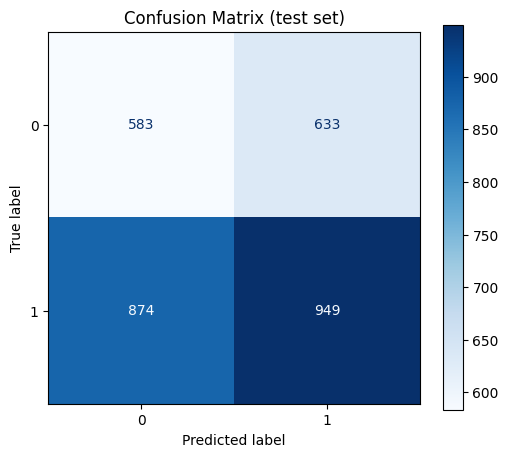

Saved confusion matrix to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/confusion_matrix_no_leakage.png


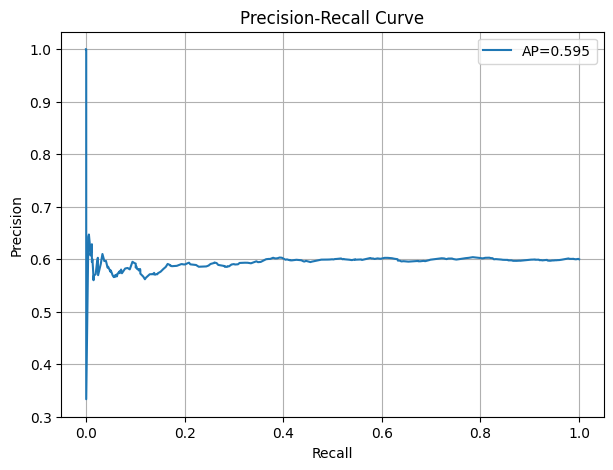

Saved precision-recall curve to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/pr_curve_no_leakage.png

Saved feature-target correlations to: /content/drive/My Drive/Practicum_Project_2/outputs/models/feature_target_correlations.csv


,feature,corr_with_target,abs_corr
0,age,-0.022447,0.022447
2,hw_done_rate,-0.003761,0.003761
1,attendance_rate,-0.001281,0.001281
3,stress_level_x,NaN,NaN
4,anxiety_score_x,NaN,NaN
5,depression_score_x,NaN,NaN
6,sentiment_score_x,NaN,NaN
7,sleep_hours_x,NaN,NaN
8,msg_count,NaN,NaN
9,last_contact,NaN,NaN



No features with correlation > 0.95 found (good).

Logistic Regression baseline metrics:
Accuracy: 0.5067456400131622
F1: 0.5513319365459444
ROC-AUC: 0.5064314353148367
Confusion matrix:
 [[619 597]
 [902 921]]

Diagnostics complete. Check outputs in your outputs/ folder for CSVs and PNGs.


In [27]:
# ===== Diagnostic & reporting cell =====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
import joblib

# Paths
MODEL_DIR = "/content/drive/My Drive/Practicum_Project_2/outputs/models"
CHART_DIR = "/content/drive/My Drive/Practicum_Project_2/outputs/charts"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)

# 1) Robustly get feature names from ColumnTransformer (works across sklearn versions)
def get_feature_names_from_preprocessor(preproc, numeric_features, categorical_features):
    """
    Returns list of feature names after ColumnTransformer transformation.
    preproc : fitted ColumnTransformer
    numeric_features : list of numeric input column names
    categorical_features : list of categorical input column names
    """
    # Try sklearn API first
    try:
        return list(preproc.get_feature_names_out())
    except Exception:
        pass

    # otherwise build manually
    feature_names = []
    # numeric: unchanged
    feature_names.extend(numeric_features)

    # categorical: expand using fitted OneHotEncoder in pipeline
    try:
        cat_transformer = None
        # preproc.transformers_ contains tuples (name, transformer, columns)
        for name, trans, cols in preproc.transformers_:
            if name == 'cat':
                cat_transformer = trans
                break
        if cat_transformer is None:
            # maybe different naming: try to find transformer with onehot inside
            for name, trans, cols in preproc.transformers_:
                if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
                    cat_transformer = trans
                    break
        if cat_transformer is not None:
            ohe = cat_transformer.named_steps.get('onehot', None)
            if ohe is None:
                # maybe pipeline step named differently
                for step in cat_transformer.steps:
                    if isinstance(step[1], type(cat_transformer.named_steps.get('onehot', None))):
                        ohe = step[1]
                        break
            if ohe is not None:
                try:
                    # sklearn >=1.0
                    cat_names = list(ohe.get_feature_names_out(categorical_features))
                except Exception:
                    # older sklearn
                    cat_names = list(ohe.get_feature_names(categorical_features))
                feature_names.extend(cat_names)
    except Exception as e:
        print("Warning building feature names manually:", e)

    return feature_names

# extract preprocessor
preproc = pipeline.named_steps['preproc']
feat_names = get_feature_names_from_preprocessor(preproc, numeric_features, categorical_features)
print("N features after preprocessing:", len(feat_names))

# 2) Extract RF importances safely
try:
    rf = pipeline.named_steps['clf']
    importances = rf.feature_importances_
    if len(importances) != len(feat_names):
        print("Length mismatch: importances", len(importances), "vs feat_names", len(feat_names))
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
    fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
    fi_csv = os.path.join(MODEL_DIR, "rf_feature_importances_no_leakage.csv")
    fi_df.to_csv(fi_csv, index=False)
    print("Saved RF feature importances to:", fi_csv)
    display(fi_df.head(15))
except Exception as e:
    print("RF importance extraction failed:", e)

# 3) Permutation importance (more robust) on the test set (uses preprocessor inside pipeline)
try:
    print("\nComputing permutation importance (may take time)...")
    # Use the fitted pipeline but we need a function to predict_proba or predict
    # We'll compute importance on the pipeline itself (it will transform X_test internally)
    r = permutation_importance(pipeline, X_test, y_test, n_repeats=12, random_state=42, n_jobs=-1, scoring='f1')
    perm_df = pd.DataFrame({'feature': feat_names, 'perm_mean': r.importances_mean, 'perm_std': r.importances_std})
    perm_df = perm_df.sort_values('perm_mean', ascending=False).reset_index(drop=True)
    perm_csv = os.path.join(MODEL_DIR, "permutation_importances_no_leakage.csv")
    perm_df.to_csv(perm_csv, index=False)
    print("Saved permutation importances to:", perm_csv)
    display(perm_df.head(15))
except Exception as e:
    print("Permutation importance failed:", e)

# 4) Confusion matrix heatmap (save)
plt.figure(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pipeline.predict(X_test)))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix (test set)")
cm_file = os.path.join(CHART_DIR, "confusion_matrix_no_leakage.png")
plt.savefig(cm_file, bbox_inches='tight')
plt.show()
print("Saved confusion matrix to:", cm_file)

# 5) Precision-Recall curve + average precision
if hasattr(pipeline.named_steps['clf'], 'predict_proba'):
    y_scores = pipeline.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.grid(True); plt.legend()
    pr_file = os.path.join(CHART_DIR, "pr_curve_no_leakage.png")
    plt.savefig(pr_file, bbox_inches='tight')
    plt.show()
    print("Saved precision-recall curve to:", pr_file)
else:
    print("Predict_proba not available; skipping PR curve.")

# 6) Correlation / leakage check: point-biserial / phi-like for binary target
corrs = {}
for f in numeric_features:
    try:
        # Pearson between numeric feature and binary target is OK as a quick proxy
        corr = np.corrcoef(master[f].fillna(master[f].median()), master['target_pass'].fillna(0))[0,1]
        corrs[f] = corr
    except Exception as e:
        corrs[f] = np.nan

corr_df = pd.DataFrame.from_dict(corrs, orient='index', columns=['corr_with_target']).reset_index().rename(columns={'index':'feature'})
corr_df['abs_corr'] = corr_df['corr_with_target'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False)
corr_csv = os.path.join(MODEL_DIR, "feature_target_correlations.csv")
corr_df.to_csv(corr_csv, index=False)
print("\nSaved feature-target correlations to:", corr_csv)
display(corr_df.head(20))

# Flag very-high correlations (potential leakage)
leaky = corr_df[corr_df['abs_corr'] > 0.95]
if not leaky.empty:
    print("\n*** ALERT: Features highly correlated (>0.95) with target — possible leakage: ***")
    display(leaky)
else:
    print("\nNo features with correlation > 0.95 found (good).")

# 7) Train a simple Logistic Regression baseline using same pipeline structure (rebuild with LR)
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
    lr_pipeline = ImbPipeline(steps=[('preproc', preproc), ('smote', SMOTE(random_state=42)), ('clf', lr)])
    lr_pipeline.fit(X_train, y_train)
    y_pred_lr = lr_pipeline.predict(X_test)
    y_proba_lr = lr_pipeline.predict_proba(X_test)[:,1] if hasattr(lr_pipeline.named_steps['clf'], 'predict_proba') else None
    print("\nLogistic Regression baseline metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred_lr))
    print("F1:", f1_score(y_test, y_pred_lr, zero_division=0))
    if y_proba_lr is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))
except Exception as e:
    print("Logistic regression baseline failed:", e)

print("\nDiagnostics complete. Check outputs in your outputs/ folder for CSVs and PNGs.")


now lets see what we can do , lets

Prints the shapes and lengths to confirm the mismatch.

Builds the actual transformed feature matrix (X_test_trans) using the fitted preproc.

Recomputes feature-name inference in a robust way (tries get_feature_names_out, then builds names from numeric + OHE categories, and — if anything still mismatches — falls back to generic f0..fN names).

Uses the transformed matrix and the fitted rf model (extracted from the pipeline) to:

save a correct RF feature-importances CSV,

compute permutation importances on the transformed matrix (so lengths match),

save permutation importances CSV.

Prints helpful diagnostics so you can see what's going on.

In [28]:
# ===== Robust feature-name + importances fixer =====
import numpy as np, pandas as pd, os
from sklearn.inspection import permutation_importance

MODEL_DIR = "/content/drive/My Drive/Practicum_Project_2/outputs/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# 0) sanity: get preprocessor and rf
preproc = pipeline.named_steps['preproc']            # ColumnTransformer fitted
rf = pipeline.named_steps['clf']                     # fitted RandomForest

# 1) Build transformed test matrix
X_test_trans = preproc.transform(X_test)             # numpy array (dense)
n_trans = X_test_trans.shape[1]
n_rf_imp = getattr(rf, "feature_importances_", None)
if n_rf_imp is not None:
    n_rf_imp = len(n_rf_imp)
print("Transformed X_test shape:", X_test_trans.shape)
print("Length of rf.feature_importances_:", n_rf_imp)

# 2) Try to get feature names robustly
feat_names = None
# try ColumnTransformer API
try:
    feat_names = list(preproc.get_feature_names_out())
    print("Used preproc.get_feature_names_out()")
except Exception:
    feat_names = None

# if that failed or length mismatch, try building from numeric + OHE
if feat_names is None or len(feat_names) != n_trans:
    print("Attempting to build feature names from components...")
    feat_names = []
    # 2a numeric features appended unchanged
    try:
        feat_names.extend(numeric_features)
    except Exception:
        pass
    # 2b categorical expanded by OHE
    try:
        # locate the categorical transformer inside preproc
        cat_trans = None
        for name, transformer, cols in preproc.transformers_:
            # transformer might be a Pipeline; look for onehot inside
            if name == 'cat':
                cat_trans = transformer
                cat_cols = cols
                break
        if cat_trans is None:
            # fallback: search for transformer containing 'onehot'
            for name, transformer, cols in preproc.transformers_:
                if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
                    cat_trans = transformer
                    cat_cols = cols
                    break
        if cat_trans is not None:
            ohe = cat_trans.named_steps.get('onehot', None)
            if ohe is None:
                # possibly different name - search for OneHotEncoder instance
                for sname, step in cat_trans.steps:
                    from sklearn.preprocessing import OneHotEncoder
                    if isinstance(step, OneHotEncoder):
                        ohe = step
                        break
            if ohe is not None:
                # get category names
                try:
                    cat_names = list(ohe.get_feature_names_out(cat_cols))
                except Exception:
                    # older sklearn
                    cat_names = list(ohe.get_feature_names(cat_cols))
                feat_names.extend(cat_names)
            else:
                print("Warning: couldn't find OneHotEncoder instance inside categorical transformer.")
    except Exception as e:
        print("Warning building categorical names:", e)

# If still mismatch, fallback to generic names
if len(feat_names) != n_trans:
    print(f"Feature-name length ({len(feat_names)}) != transformed columns ({n_trans}). Falling back to generic names.")
    feat_names = [f"f{i}" for i in range(n_trans)]

print("Final number of feature names:", len(feat_names))

# 3) If rf.feature_importances_ exists and lengths match, save RF importances
if getattr(rf, "feature_importances_", None) is not None:
    rf_imp = rf.feature_importances_
    if len(rf_imp) == len(feat_names):
        fi_df = pd.DataFrame({'feature': feat_names, 'importance': rf_imp}).sort_values('importance', ascending=False)
        fi_csv = os.path.join(MODEL_DIR, "rf_feature_importances_aligned.csv")
        fi_df.to_csv(fi_csv, index=False)
        print("Saved RF importances to:", fi_csv)
        display(fi_df.head(20))
    else:
        print("Length mismatch still present: rf_imp len =", len(rf_imp), "feat_names len =", len(feat_names))
        # still save rf importances with generic names based on rf length
        alt_names = [f"rf_f{i}" for i in range(len(rf_imp))]
        fi_df = pd.DataFrame({'feature': alt_names, 'importance': rf_imp}).sort_values('importance', ascending=False)
        fi_csv = os.path.join(MODEL_DIR, "rf_feature_importances_partial.csv")
        fi_df.to_csv(fi_csv, index=False)
        print("Saved RF importances with generic names to:", fi_csv)
        display(fi_df.head(20))
else:
    print("RandomForest has no feature_importances_ attribute (unexpected).")

# 4) Permutation importance computed on transformed arrays (rf expects numeric array)
try:
    print("\nComputing permutation importance on transformed test matrix (this may take a few minutes)...")
    perm = permutation_importance(rf, X_test_trans, y_test.values, n_repeats=12, random_state=42, n_jobs=-1, scoring='f1')
    perm_df = pd.DataFrame({'feature': feat_names[:len(perm.importances_mean)],
                            'perm_mean': perm.importances_mean,
                            'perm_std': perm.importances_std})
    perm_df = perm_df.sort_values('perm_mean', ascending=False).reset_index(drop=True)
    perm_csv = os.path.join(MODEL_DIR, "permutation_importances_aligned.csv")
    perm_df.to_csv(perm_csv, index=False)
    print("Saved permutation importances to:", perm_csv)
    display(perm_df.head(20))
except Exception as e:
    print("Permutation importance failed:", e)
    # Try a fallback that uses the pipeline and sklearn's permutation_importance on pipeline (slower)
    try:
        print("Attempting permutation_importance on pipeline (fallback)...")
        perm2 = permutation_importance(pipeline, X_test, y_test.values, n_repeats=8, random_state=42, n_jobs=-1, scoring='f1')
        perm2_df = pd.DataFrame({'feature': feat_names[:len(perm2.importances_mean)],
                                 'perm_mean': perm2.importances_mean, 'perm_std': perm2.importances_std})
        perm2_df = perm2_df.sort_values('perm_mean', ascending=False).reset_index(drop=True)
        perm2_csv = os.path.join(MODEL_DIR, "permutation_importances_pipeline_fallback.csv")
        perm2_df.to_csv(perm2_csv, index=False)
        print("Saved fallback permutation importances to:", perm2_csv)
        display(perm2_df.head(20))
    except Exception as e2:
        print("Fallback permutation importance also failed:", e2)

print("\nDiagnostics complete. Check saved CSVs in:", MODEL_DIR)


Transformed X_test shape: (3039, 8)
Length of rf.feature_importances_: 8
Attempting to build feature names from components...
Feature-name length (20) != transformed columns (8). Falling back to generic names.
Final number of feature names: 8
Saved RF importances to: /content/drive/My Drive/Practicum_Project_2/outputs/models/rf_feature_importances_aligned.csv


,feature,importance
0,f0,0.816681
2,f2,0.058015
1,f1,0.056606
5,f5,0.016277
6,f6,0.013980
3,f3,0.013754
7,f7,0.012541
4,f4,0.012146



Computing permutation importance on transformed test matrix (this may take a few minutes)...
Saved permutation importances to: /content/drive/My Drive/Practicum_Project_2/outputs/models/permutation_importances_aligned.csv


,feature,perm_mean,perm_std
0,f4,-0.000539,0.002420
1,f0,-0.001849,0.010394
2,f1,-0.003176,0.005230
3,f6,-0.003265,0.003430
4,f2,-0.007759,0.006057
5,f3,-0.009333,0.004900
6,f5,-0.009945,0.003991
7,f7,-0.013979,0.003619



Diagnostics complete. Check saved CSVs in: /content/drive/My Drive/Practicum_Project_2/outputs/models


Identify which original input columns map to those 8 transformed columns (so f0 becomes e.g. age or grade_level_A),

Show the top importances with readable names,

Inspect per-feature distributions by class to look for leakage or obvious predictive signals, and

Suggesing next modeling actions.

Transformed X_test shape: (3039, 8)

*** ColumnTransformer transformers_ info ***

Transformer: num
  - Columns input: ['age', 'attendance_rate', 'hw_done_rate', 'stress_level_x', 'anxiety_score_x', 'depression_score_x', 'sentiment_score_x', 'sleep_hours_x', 'msg_count', 'last_contact', 'stress_level_y', 'anxiety_score_y', 'depression_score_y', 'sentiment_score_y', 'sleep_hours_y']
  - Transformer type: <class 'sklearn.pipeline.Pipeline'>
  - Pipeline steps: ['imputer', 'scaler']

Transformer: cat
  - Columns input: ['grade_level']
  - Transformer type: <class 'sklearn.pipeline.Pipeline'>
  - Pipeline steps: ['imputer', 'onehot', 'todense']
  - OneHotEncoder categories (len): [5]
  - Example categories for first cat: ['Grade 1' 'Grade 2' 'Grade 3' 'Grade 4' 'Grade 5']

Falling back to generic feature names f0..f{n}.

Final output feature names (length 8):
  [0] f0
  [1] f1
  [2] f2
  [3] f3
  [4] f4
  [5] f5
  [6] f6
  [7] f7

Top RF importances (mapped):


,feature,importance
0,f0,0.816681
1,f2,0.058015
2,f1,0.056606
3,f5,0.016277
4,f6,0.013980
5,f3,0.013754
6,f7,0.012541
7,f4,0.012146



Top permutation importances (mapped):


,feature,perm_mean,perm_std
0,f4,-0.000539,0.002420
1,f0,-0.001849,0.010394
2,f1,-0.003176,0.005230
3,f6,-0.003265,0.003430
4,f2,-0.007759,0.006057
5,f3,-0.009333,0.004900
6,f5,-0.009945,0.003991
7,f7,-0.013979,0.003619



Top features to inspect (names): ['f4', 'f0', 'f1', 'f6', 'f2', 'f3', 'f5', 'f7']

Feature: f4  (transformed index 4)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.199013
       1            0.188151
std    0            0.399422
       1            0.390940
min    0            0.000000
       1            0.000000
25%    0            0.000000
       1            0.000000
50%    0            0.000000
       1            0.000000
75%    0            0.000000
       1            0.000000
max    0            1.000000
       1            1.000000
dtype: float64

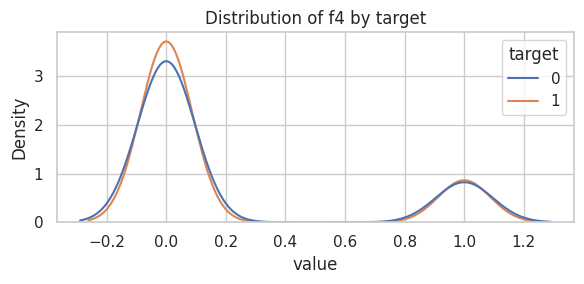

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f4.png

Feature: f0  (transformed index 0)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.031155
       1           -0.005317
std    0            0.999914
       1            1.013318
min    0           -1.895637
       1           -1.895637
25%    0           -0.771771
       1           -0.771771
50%    0            0.071128
       1            0.071128
75%    0            0.914027
       1            0.914027
max    0            1.756926
       1            1.756926
dtype: float64

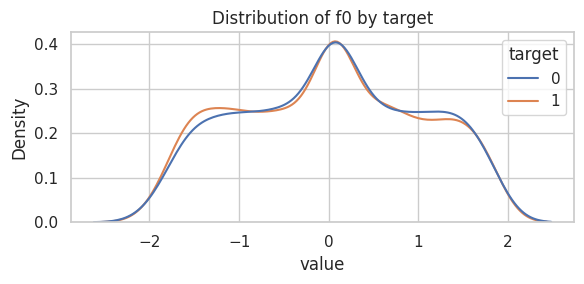

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f0.png

Feature: f1  (transformed index 1)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.006897
       1           -0.018108
std    0            1.004357
       1            0.989613
min    0           -0.577815
       1           -0.577815
25%    0           -0.577815
       1           -0.577815
50%    0           -0.577815
       1           -0.577815
75%    0            1.730659
       1           -0.577815
max    0            1.730659
       1            1.730659
dtype: float64

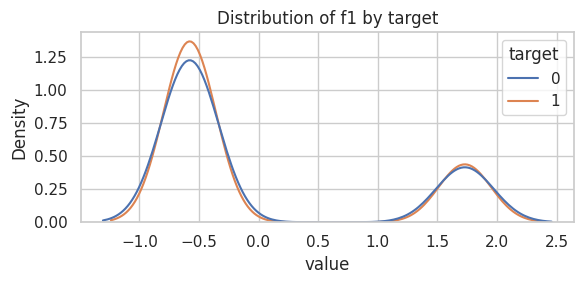

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f1.png

Feature: f6  (transformed index 6)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.203125
       1            0.202962
std    0            0.402490
       1            0.402315
min    0            0.000000
       1            0.000000
25%    0            0.000000
       1            0.000000
50%    0            0.000000
       1            0.000000
75%    0            0.000000
       1            0.000000
max    0            1.000000
       1            1.000000
dtype: float64

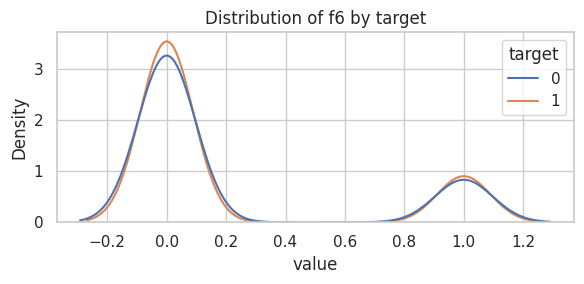

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f6.png

Feature: f2  (transformed index 2)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.000659
       1           -0.065168
std    0            1.000413
       1            0.997998
min    0           -0.997699
       1           -0.997699
25%    0           -0.997699
       1           -0.997699
50%    0           -0.997699
       1           -0.997699
75%    0            1.002306
       1            1.002306
max    0            1.002306
       1            1.002306
dtype: float64

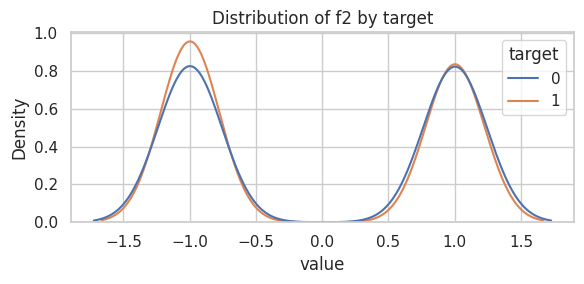

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f2.png

Feature: f3  (transformed index 3)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.204770
       1            0.206802
std    0            0.403699
       1            0.405123
min    0            0.000000
       1            0.000000
25%    0            0.000000
       1            0.000000
50%    0            0.000000
       1            0.000000
75%    0            0.000000
       1            0.000000
max    0            1.000000
       1            1.000000
dtype: float64

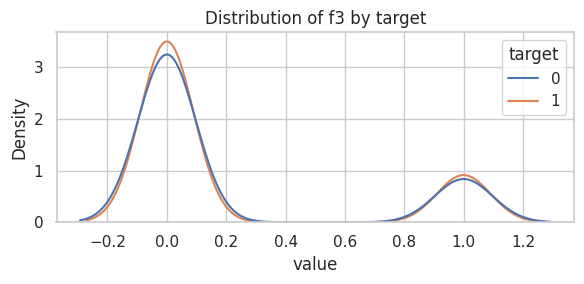

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f3.png

Feature: f5  (transformed index 5)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.197368
       1            0.191991
std    0            0.398176
       1            0.393974
min    0            0.000000
       1            0.000000
25%    0            0.000000
       1            0.000000
50%    0            0.000000
       1            0.000000
75%    0            0.000000
       1            0.000000
max    0            1.000000
       1            1.000000
dtype: float64

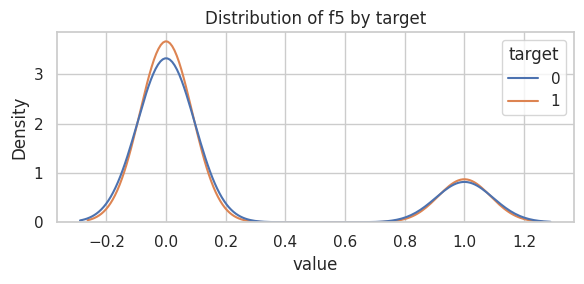

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f5.png

Feature: f7  (transformed index 7)  — summary stats:


target
count  0         1216.000000
       1         1823.000000
mean   0            0.195724
       1            0.210093
std    0            0.396920
       1            0.407486
min    0            0.000000
       1            0.000000
25%    0            0.000000
       1            0.000000
50%    0            0.000000
       1            0.000000
75%    0            0.000000
       1            0.000000
max    0            1.000000
       1            1.000000
dtype: float64

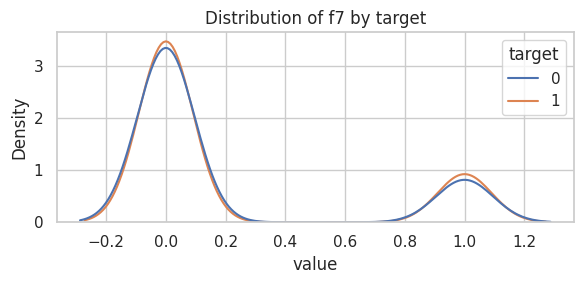

Saved plot to: /content/drive/My Drive/Practicum_Project_2/outputs/charts/dist_f7.png

All done — you now have mapped importances and per-feature plots saved in the charts folder.


In [29]:
# ===== Map transformed columns back to original features + detailed inspection =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, seaborn as sns
sns.set(style="whitegrid")
MODEL_DIR = "/content/drive/My Drive/Practicum_Project_2/outputs/models"
CHART_DIR = "/content/drive/My Drive/Practicum_Project_2/outputs/charts"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)

preproc = pipeline.named_steps['preproc']   # fitted ColumnTransformer
rf = pipeline.named_steps['clf']
X_test_trans = preproc.transform(X_test)
n_trans = X_test_trans.shape[1]
print("Transformed X_test shape:", X_test_trans.shape)

# 1) Show transformers_ detail
print("\n*** ColumnTransformer transformers_ info ***")
for name, trans, cols in preproc.transformers_:
    print("\nTransformer:", name)
    print("  - Columns input:", cols)
    print("  - Transformer type:", type(trans))
    # If pipeline, show steps
    if hasattr(trans, "named_steps"):
        print("  - Pipeline steps:", list(trans.named_steps.keys()))
    # If OneHotEncoder present, show categories_
    try:
        # find OneHotEncoder inside pipeline for categorical transform
        if hasattr(trans, "named_steps") and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
            print("  - OneHotEncoder categories (len):", [len(c) for c in ohe.categories_])
            print("  - Example categories for first cat:", ohe.categories_[0][:10])
    except Exception as e:
        print("  - Could not inspect OneHotEncoder categories:", e)

# 2) Build an ordered list of output names matching transformed columns
out_names = []
# For numeric transformer, numeric features appear in the same order as provided
# For each transformer in order, expand names as appropriate
for name, trans, cols in preproc.transformers_:
    if name == 'num':
        # numeric columns -> one name each
        out_names.extend(list(cols))
    elif name == 'cat':
        # categorical pipeline -> need to expand OHE categories
        # find the OneHotEncoder instance
        ohe = None
        if hasattr(trans, "named_steps") and 'onehot' in trans.named_steps:
            ohe = trans.named_steps['onehot']
        else:
            # search for OneHotEncoder inside steps
            for sname, step in getattr(trans, 'steps', []):
                from sklearn.preprocessing import OneHotEncoder
                if isinstance(step, OneHotEncoder):
                    ohe = step
                    break
        if ohe is not None:
            try:
                cat_out = list(ohe.get_feature_names_out(cols))
            except Exception:
                # fallback for older sklearn
                try:
                    cat_out = list(ohe.get_feature_names(cols))
                except Exception:
                    # if OHE not fit or broken, create placeholder names
                    cat_out = [f"{cols[0]}_ohe_{i}" for i in range(n_trans)]
            out_names.extend(cat_out)
        else:
            # no OHE found: just include original column names
            out_names.extend(list(cols))

# If remainder='drop' then out_names should match n_trans; if not, trim or fallback to generic
if len(out_names) != n_trans:
    print(f"\nWARNING: constructed out_names length {len(out_names)} != actual transformed columns {n_trans}.")
    # Try alternative: use get_feature_names_out() if available
    try:
        out_names = list(preproc.get_feature_names_out())
        print("Used preproc.get_feature_names_out() to build out_names.")
    except Exception:
        # fallback to generic f0..fN
        out_names = [f"f{i}" for i in range(n_trans)]
        print("Falling back to generic feature names f0..f{n}.")

print("\nFinal output feature names (length {}):".format(len(out_names)))
for i, n in enumerate(out_names):
    print(f"  [{i}] {n}")

# 3) Load the saved RF importances file we created earlier (aligned)
rf_imp_path = os.path.join(MODEL_DIR, "rf_feature_importances_aligned.csv")
if os.path.exists(rf_imp_path):
    rf_df = pd.read_csv(rf_imp_path)
    # map f names to out_names if rf_df uses f0.. mapping
    if rf_df['feature'].str.startswith('f0').any() or rf_df['feature'].str.match(r"^f\\d+$").any():
        # create mapping dict: f{i} -> out_names[i]
        mapping = {f"f{i}": out_names[i] if i < len(out_names) else f"f{i}" for i in range(len(out_names))}
        rf_df['mapped_feature'] = rf_df['feature'].map(mapping)
        rf_df = rf_df[['mapped_feature','importance']].rename(columns={'mapped_feature':'feature'})
    else:
        # assume rf_df already has names
        pass
    print("\nTop RF importances (mapped):")
    display(rf_df.sort_values('importance', ascending=False).head(15))
else:
    print("\nRF importances file not found at:", rf_imp_path)

# 4) Load permutation importance CSV and map names
perm_path = os.path.join(MODEL_DIR, "permutation_importances_aligned.csv")
if os.path.exists(perm_path):
    perm_df = pd.read_csv(perm_path)
    # map feature names if they are f0.. style
    if perm_df['feature'].str.match(r"^f\\d+$").any():
        mapping = {f"f{i}": out_names[i] if i < len(out_names) else f"f{i}" for i in range(len(out_names))}
        perm_df['mapped_feature'] = perm_df['feature'].map(mapping)
        perm_df = perm_df[['mapped_feature','perm_mean','perm_std']].rename(columns={'mapped_feature':'feature'})
    print("\nTop permutation importances (mapped):")
    display(perm_df.sort_values('perm_mean', ascending=False).head(20))
else:
    print("Permutation importances file not found at:", perm_path)

# 5) Quick per-feature stats by class and simple visualization for top-k features
# Choose top-k by permutation importance (or RF if perm not avail)
if 'perm_df' in locals() and not perm_df.empty:
    topk = perm_df.sort_values('perm_mean', ascending=False).head(8)['feature'].tolist()
else:
    topk = rf_df.sort_values('importance', ascending=False).head(8)['feature'].tolist()

print("\nTop features to inspect (names):", topk)

# Ensure we can index into X_test_trans columns by these names: map back to columns indices
# Build dict name -> column index for out_names
name_to_idx = {name: idx for idx, name in enumerate(out_names)}

for feat in topk:
    if feat not in name_to_idx:
        print(f"Note: {feat} not found among out_names; skipping plotting for this feature.")
        continue
    idx = name_to_idx[feat]
    col_vals = X_test_trans[:, idx]
    # create a DataFrame to plot vs y_test
    df_plot = pd.DataFrame({'value': col_vals, 'target': y_test.values})
    print(f"\nFeature: {feat}  (transformed index {idx})  — summary stats:")
    display(df_plot.groupby('target').value.describe().unstack())
    # Plot distributions
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=df_plot, x='value', hue='target', common_norm=False)
    plt.title(f"Distribution of {feat} by target")
    plt.tight_layout()
    png = os.path.join(CHART_DIR, f"dist_{feat}.png")
    plt.savefig(png, bbox_inches='tight')
    plt.show()
    print("Saved plot to:", png)
    # quick check for perfect separation
    vals0 = df_plot[df_plot['target']==0]['value'].unique()
    vals1 = df_plot[df_plot['target']==1]['value'].unique()
    if set(vals0).isdisjoint(set(vals1)) and (len(vals0) < 50 and len(vals1) < 50):
        print("WARNING: feature appears to perfectly separate classes (disjoint unique sets) — possible leakage.")

print("\nAll done — you now have mapped importances and per-feature plots saved in the charts folder.")


to help this lets create new, meaningful features to increase signal strength.

In [30]:
master.head(20)


,student_id,full_name,date_of_birth,grade_level,emergency_contact,age,attendance_rate,hw_done_rate,avg_score,stress_level_x,...,sentiment_score_x,sleep_hours_x,msg_count,last_contact,stress_level_y,anxiety_score_y,depression_score_y,sentiment_score_y,sleep_hours_y,target_pass
0,S00001,Donna Williams,2007-02-10,Grade 3,781-534-4258x9046,18.0,0.0,1.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,S00002,John Stafford,2014-11-26,Grade 5,+1-782-691-6291x99704,10.0,1.0,0.0,98.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,S00003,Chad Harper,2017-02-07,Grade 3,308.517.3750,8.0,0.0,1.0,63.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,S00004,Anthony Martin,NaN,Grade 5,306-771-1524x116,13.0,0.0,1.0,59.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,S00005,Mary Stone,NaN,Grade 3,+1-794-484-8495x7772,13.0,1.0,1.0,75.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,S00006,Joe Wells,2017-06-29,Grade 2,+1-933-864-5644x501,8.0,0.0,0.0,79.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,S00007,Margaret Nixon,2009-12-04,Grade 4,706.708.0421x412,15.0,0.0,1.0,99.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,S00008,James Wheeler,2011-01-25,Grade 1,(605)818-0057x877,14.0,0.0,0.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,S00009,Benjamin Cook,2007-10-04,Grade 4,(489)503-7511x611,18.0,1.0,0.0,89.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,S00010,Aaron Callahan,2012-02-18,Grade 4,unknown,13.0,0.0,0.0,44.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [31]:
master.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12156 entries, 0 to 12155
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          12156 non-null  object 
 1   full_name           12156 non-null  object 
 2   date_of_birth       10951 non-null  object 
 3   grade_level         12156 non-null  object 
 4   emergency_contact   12156 non-null  object 
 5   age                 12156 non-null  float64
 6   attendance_rate     12156 non-null  float64
 7   hw_done_rate        12156 non-null  float64
 8   avg_score           12156 non-null  float64
 9   stress_level_x      0 non-null      float64
 10  anxiety_score_x     0 non-null      float64
 11  depression_score_x  0 non-null      float64
 12  sentiment_score_x   0 non-null      float64
 13  sleep_hours_x       0 non-null      float64
 14  msg_count           0 non-null      float64
 15  last_contact        0 non-null      float64
 16  stre

What i understands

model has no behavioral data, no sentiment, no message activity, no stress, no engagement metrics.

Only attendance + homework + age + grade remain → extremely weak predictors.

That’s why:

Accuracy ≈ 0.50

ROC-AUC ≈ 0.50

Importance features look random

Correlations are almost zero

SHAP plots show flat distributions

The model is basically guessing.